# Neural Analysis Demo

This notebook demonstrates:
- Distance calculations (pairwise, within/between distributions)
- Distribution comparison metrics
- Outlier detection methods (IQR, Z-score, LOF, Isolation Forest, Elliptic)
- Visualizations using the built-in plotting utilities


In [ ]:
# Imports
import numpy as np
import time

# Import from metrics submodules directly to avoid kernel cache issues
from neural_analysis.metrics.distance import (
    pairwise_distance,
    distribution_distance,
)
from neural_analysis.metrics.distributions import compare_distributions
from neural_analysis.metrics.outliers import filter_outlier
from neural_analysis.metrics.similarity import similarity_matrix

from neural_analysis.plotting import (
    set_backend,
    PlotConfig,
    plot_grouped_scatter_2d,
    plot_kde_2d,
    plot_line,
    plot_heatmap,
    create_subplot_grid,
)

# Use matplotlib for static plots in this demo
set_backend('matplotlib')

In [10]:
# Generate synthetic 2D datasets (A and B) with known structure
np.random.seed(42)

n_per_group = 200
mean_A = np.array([0.0, 0.0])
mean_B = np.array([2.0, 1.0])
cov = np.array([[1.0, 0.3],[0.3, 0.8]])

A = np.random.multivariate_normal(mean_A, cov, size=n_per_group)
B = np.random.multivariate_normal(mean_B, cov, size=n_per_group)

# Inject a few strong outliers into B
outliers = np.random.randn(8, 2) * 6 + np.array([6.0, -6.0])
B_with_outliers = np.vstack([B, outliers])

print(f"A shape: {A.shape}, B shape: {B.shape}, B_with_outliers: {B_with_outliers.shape}")


A shape: (200, 2), B shape: (200, 2), B_with_outliers: (208, 2)


<Axes: title={'center': 'Grouped scatter: A vs B'}, xlabel='X', ylabel='Y'>

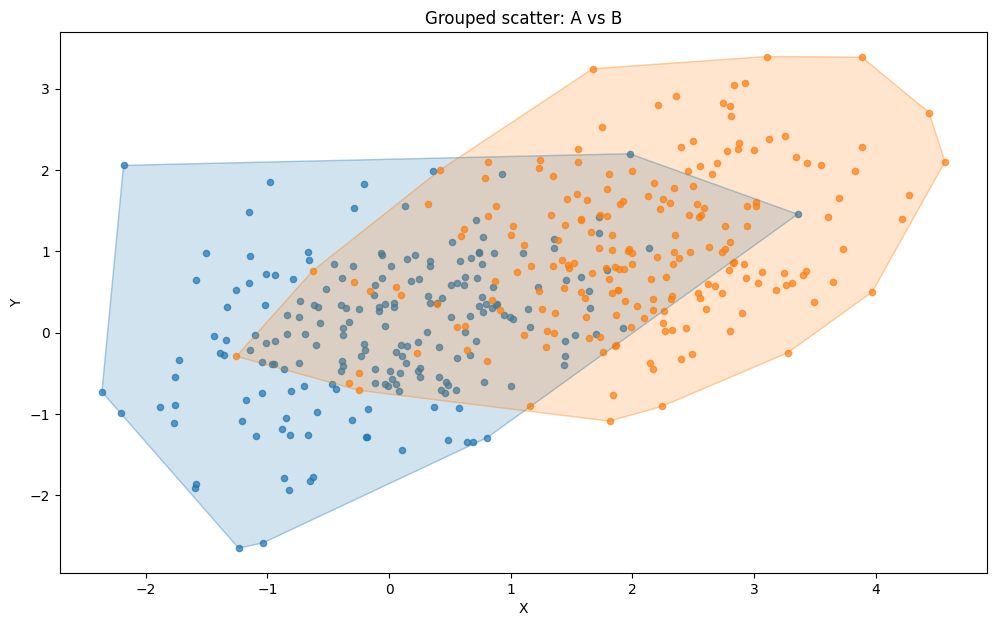

In [3]:
# Visualize distributions A and B (grouped scatter)
config = PlotConfig(title="Grouped scatter: A vs B", xlabel="X", ylabel="Y", show=True)
plot_grouped_scatter_2d({"A": (A[:,0], A[:,1]), "B": (B[:,0], B[:,1])}, config=config)


Pairwise distance matrix shape: (50, 50)
Within A: {'mean': 1.596818781121446, 'std': 0.8767854730135421, 'median': 1.4717597869283665, 'min': 0.01165120536327024, 'max': 6.160976839519321}
Within B: {'mean': 1.681182932584051, 'std': 0.9155919730332672, 'median': 1.5522060823715624, 'min': 0.002786294193343759, 'max': 6.432507936266354}
Between A and B: {'mean': 2.6798188451290286, 'std': 1.2870787689176604, 'median': 2.5854354539814794, 'min': 0.011907837226573148, 'max': 7.915453799566353}


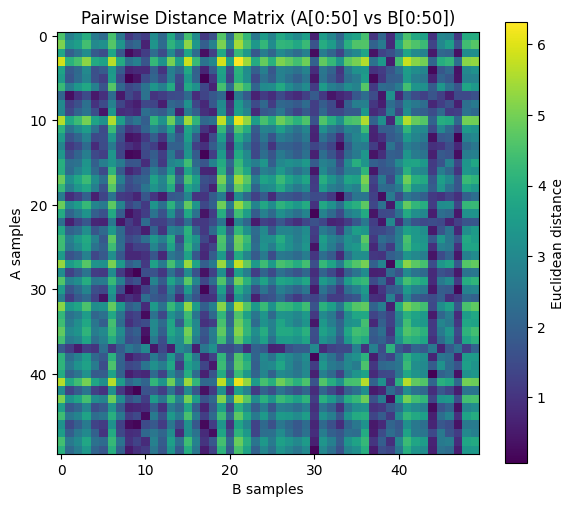

In [12]:
# Distance calculations: pairwise and summaries
# Pairwise Euclidean distance between subsets (for visualization and scale)
X = A[:50]
Y = B[:50]
D = pairwise_distance(X, Y, metric="euclidean")
print("Pairwise distance matrix shape:", D.shape)

# Show a quick heatmap of the pairwise distances using PlotGrid system
config = PlotConfig(
    title='Pairwise Distance Matrix (A[0:50] vs B[0:50])',
    xlabel='B samples',
    ylabel='A samples',
    figsize=(6, 5),
    show=True
)
plot_heatmap(
    D,
    config=config,
    cmap='viridis',
    colorbar=True,
    colorbar_label='Euclidean distance',
    backend='matplotlib'
)

# Within and between distribution summaries
within_A = distribution_distance(A, mode="within", metric="euclidean", summary="all")
within_B = distribution_distance(B, mode="within", metric="euclidean", summary="all")
between_AB = distribution_distance(A, B, mode="between", metric="euclidean", summary="all")

print("Within A:", within_A)
print("Within B:", within_B)
print("Between A and B:", between_AB)


         wasserstein: 3.0938
  kolmogorov-smirnov: 0.7500
      jensen-shannon: 0.6407
           euclidean: 2.3160
              cosine: -0.3833


<Axes: title={'center': 'KDE of Combined A and B'}, xlabel='X', ylabel='Y'>

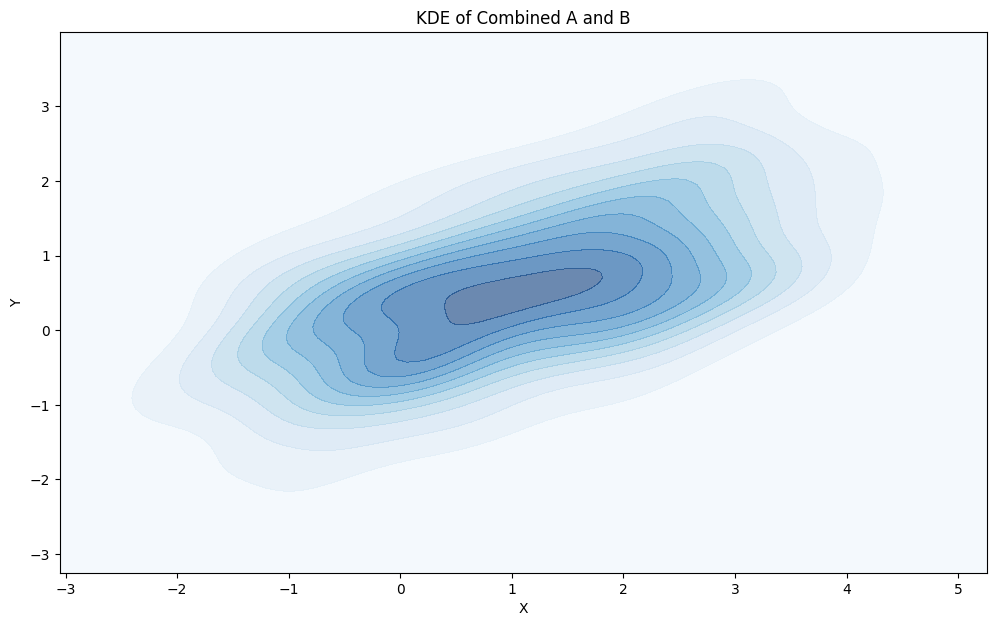

In [5]:
# Distribution comparison metrics
metrics = ["wasserstein", "kolmogorov-smirnov", "jensen-shannon", "euclidean", "cosine"]
results = {}
for m in metrics:
    results[m] = compare_distributions(A, B, metric=m)

for m, v in results.items():
    print(f"{m:>20}: {v:.4f}")

# Show KDE overlay of combined distributions to visualize overlap
config = PlotConfig(title="KDE of Combined A and B", xlabel="X", ylabel="Y", show=True)
plot_kde_2d(np.concatenate([A[:,0], B[:,0]]), np.concatenate([A[:,1], B[:,1]]), config=config, show_points=False)


Remaining points after filtering:
        iqr: 200 / 208
     zscore: 199 / 208
        lof: 197 / 208
  isolation: 197 / 208
   elliptic: 197 / 208


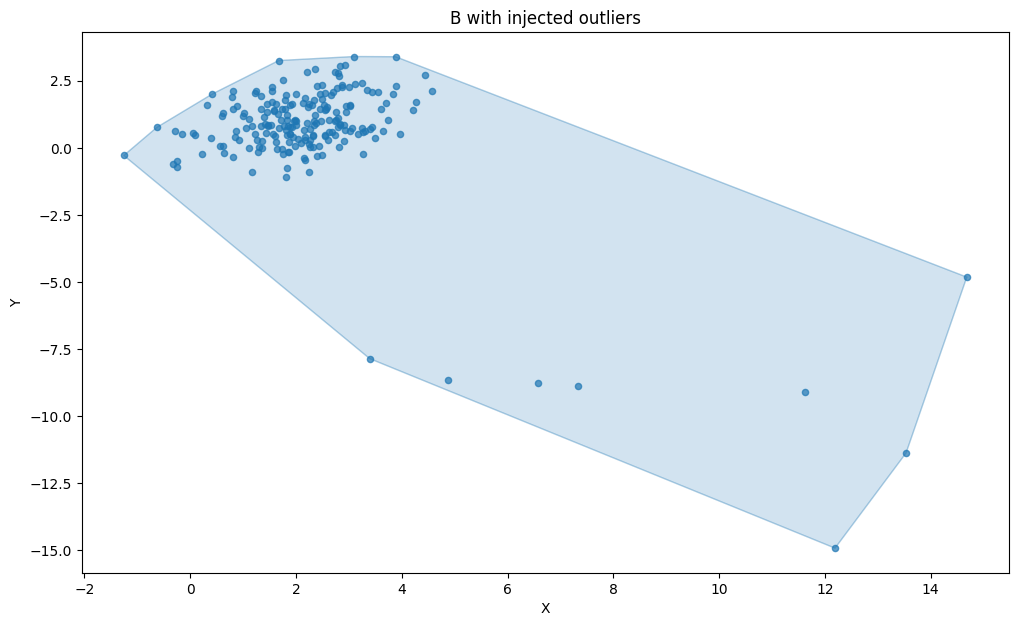

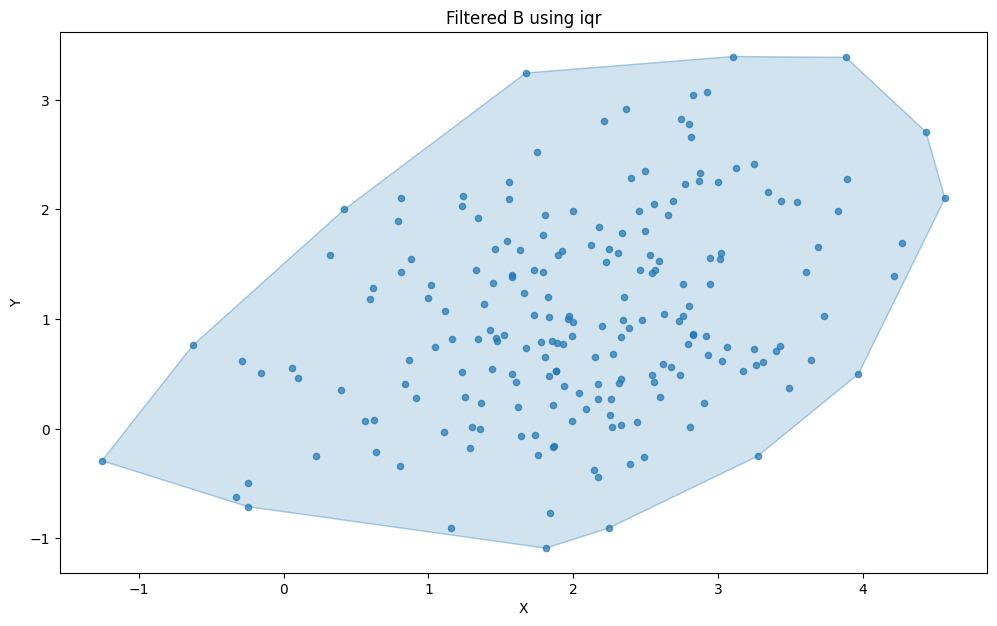

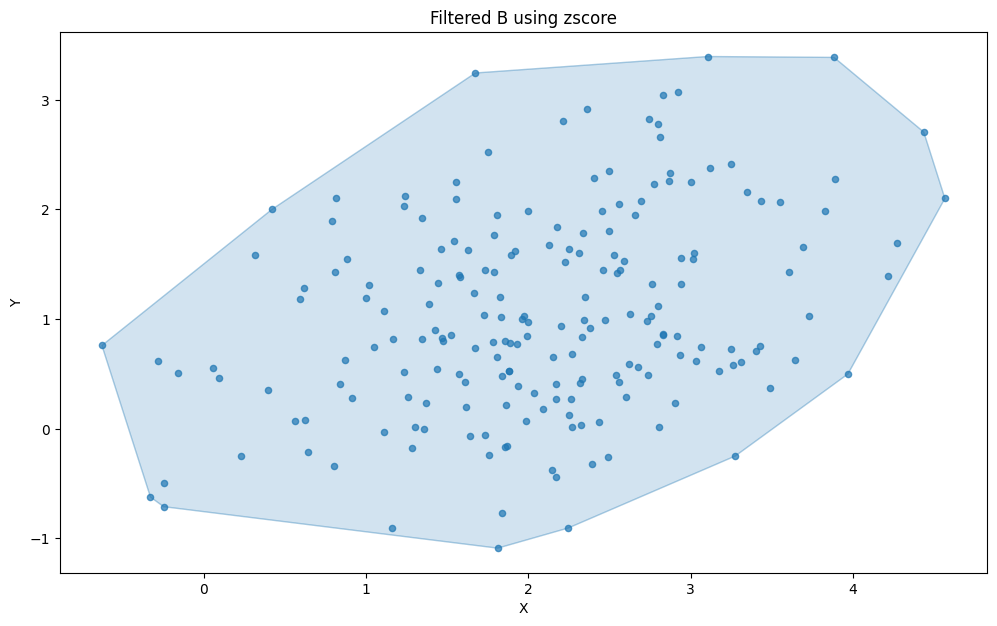

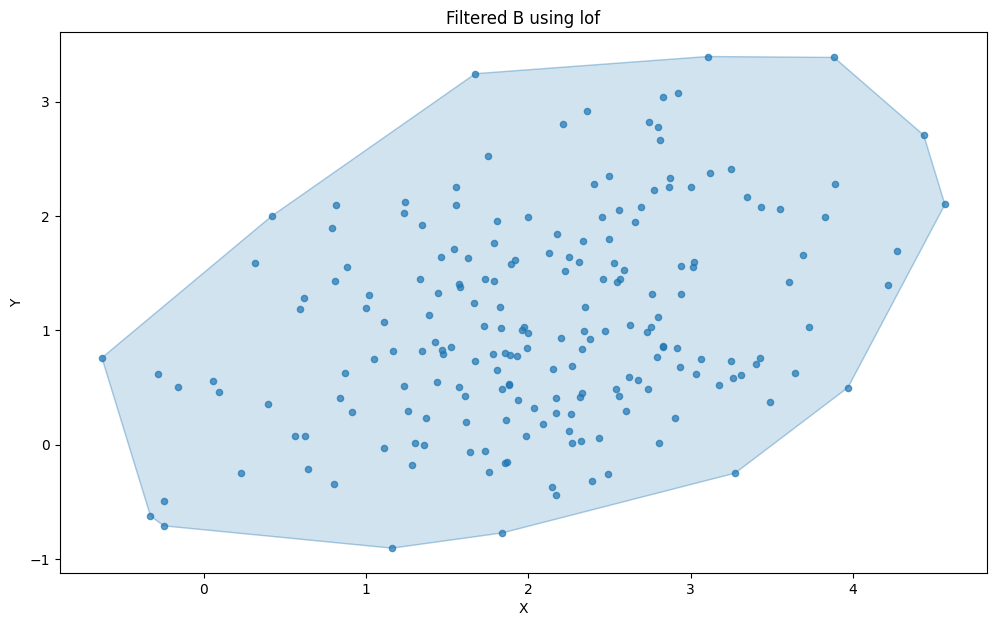

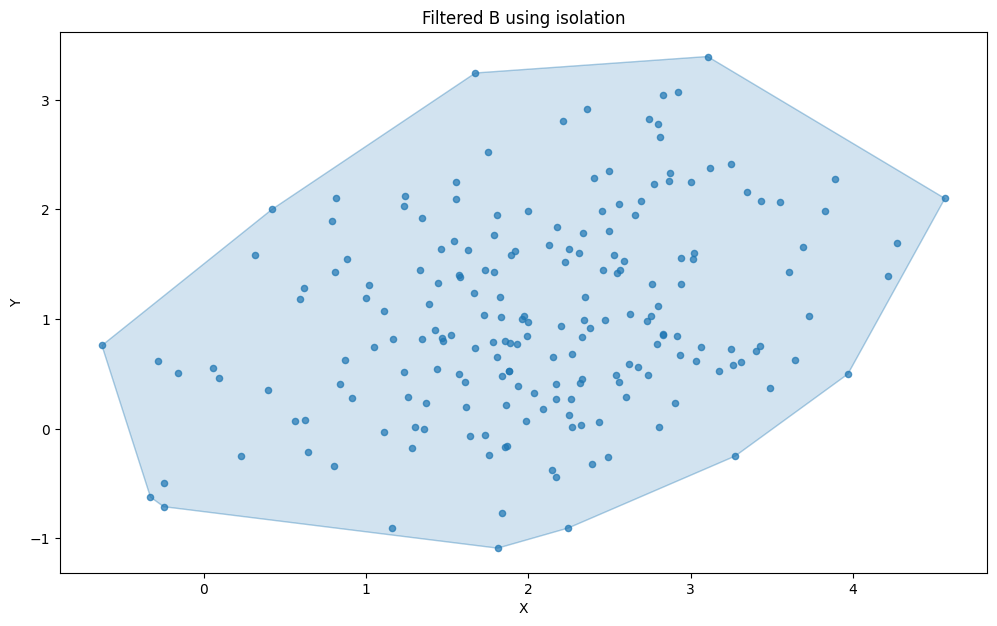

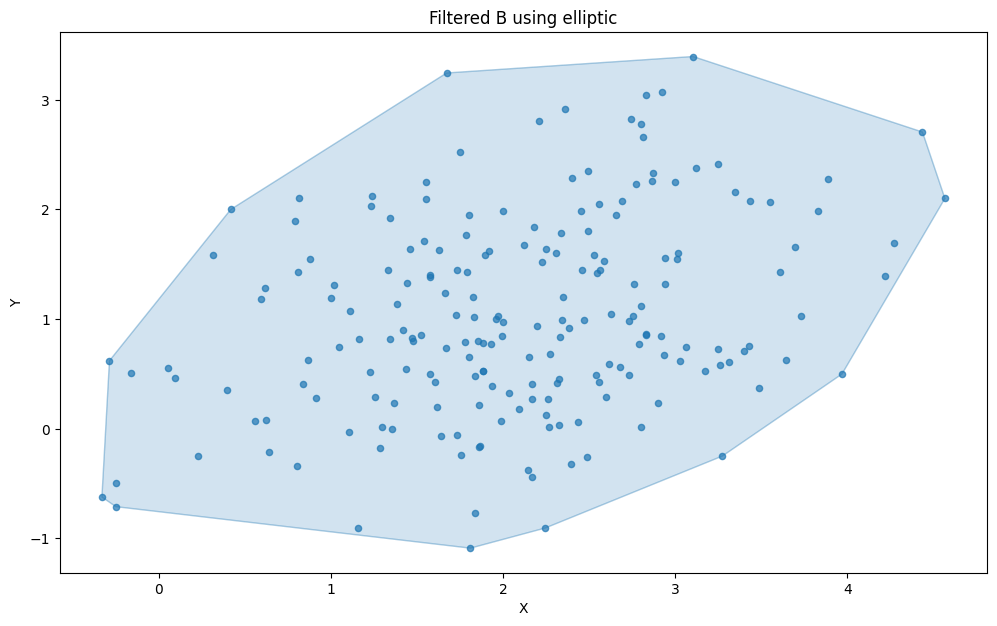

In [6]:
# Outlier detection: compare methods on B_with_outliers
# Visualize original B_with_outliers
config = PlotConfig(title="B with injected outliers", xlabel="X", ylabel="Y", show=True)
plot_grouped_scatter_2d({"B_raw": (B_with_outliers[:,0], B_with_outliers[:,1])}, config=config)

# Apply different methods
methods = ["iqr", "zscore", "lof", "isolation", "elliptic"]
filtered_counts = {}
for method in methods:
    filtered = filter_outlier(B_with_outliers, method=method, contamination=0.05, threshold=3.0)
    filtered_counts[method] = filtered.shape[0]
    config = PlotConfig(title=f"Filtered B using {method}", xlabel="X", ylabel="Y", show=True)
    plot_grouped_scatter_2d({f"B_{method}": (filtered[:,0], filtered[:,1])}, config=config)

print("Remaining points after filtering:")
for m, c in filtered_counts.items():
    print(f"  {m:>9}: {c} / {B_with_outliers.shape[0]}")


Correlation matrix (combined A and B across 4 dimensions):
[[ 1.     0.337 -0.182 -0.033]
 [ 0.337  1.     0.025 -0.026]
 [-0.182  0.025  1.     0.347]
 [-0.033 -0.026  0.347  1.   ]]


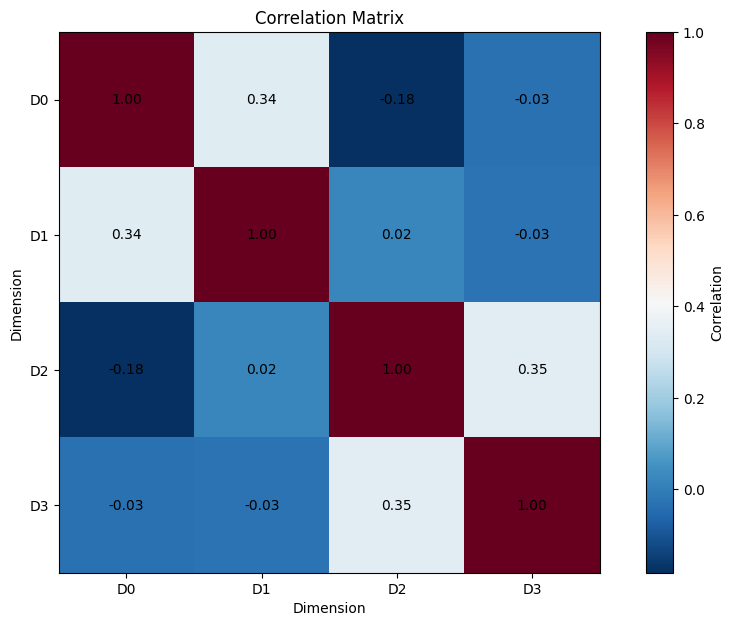

In [ ]:
# Compute correlation matrix and visualize
# Combine A and B to see correlations between dimensions
combined = np.hstack([A, B])  # shape: (200, 4)

# Compute Pearson correlation
corr = similarity_matrix(combined, method='pearson')
print("Correlation matrix (combined A and B across 4 dimensions):")
print(corr.round(3))

# Visualize as heatmap
fig = plot_heatmap(
    corr,
    config=PlotConfig(title="Correlation Matrix", xlabel="Dimension", ylabel="Dimension"),
    x_labels=[f"D{i}" for i in range(4)],
    y_labels=[f"D{i}" for i in range(4)],
    cmap='RdBu_r',
    show_values=True,
    value_format='.2f',
    colorbar_label="Correlation",
    backend='matplotlib'
)

Timing on 5000x50: LOF ~ 0.35s, IsolationForest ~ 0.13s


<Axes: title={'center': 'Timing comparison (lower is better)'}, xlabel='method', ylabel='seconds'>

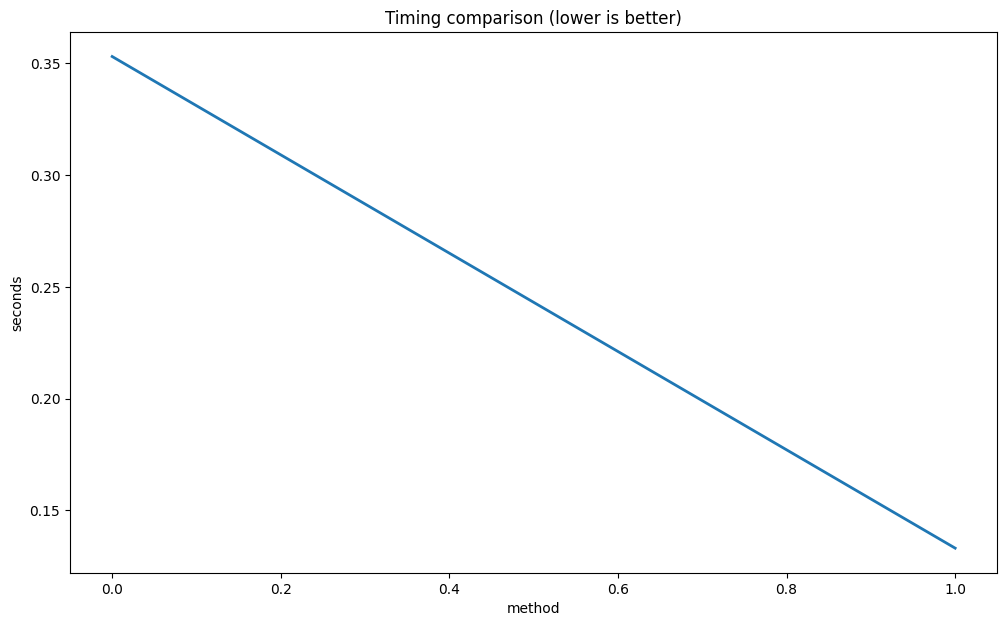

In [8]:
# Parallel processing performance (illustrative)
# Compare timing for LOF and IsolationForest on higher-dimensional data
np.random.seed(123)
X_hd = np.random.randn(5000, 50)
X_hd[:100] += 5.0  # inject outliers

# LOF timing
start = time.time()
_ = filter_outlier(X_hd, method='lof', contamination=0.02, return_mask=False)
t_lof = time.time() - start

# Isolation Forest timing (leverages n_jobs=-1 internally)
start = time.time()
_ = filter_outlier(X_hd, method='isolation', contamination=0.02, return_mask=False)
t_iso = time.time() - start

print(f"Timing on 5000x50: LOF ~ {t_lof:.2f}s, IsolationForest ~ {t_iso:.2f}s")

# Plot timing as a simple line for quick comparison
config = PlotConfig(title="Timing comparison (lower is better)", xlabel="method", ylabel="seconds", show=True)
plot_line(np.array([t_lof, t_iso]), x=np.array([0,1]), config=config)


# Summary

## What We Demonstrated
- Computed pairwise and summary distances using unified `distribution_distance()` API
- Applied multiple distribution comparison metrics with `compare_distributions()`
- Detected outliers with several methods using `filter_outlier()`
- Visualized data and results with modular plotting utilities

## Quick Reference: When to Use Each Method

### Distance Metrics

**Choose based on your data structure:**
- **Euclidean**: Default choice for spherical clusters, equal feature importance
- **Mahalanobis**: Use when features are correlated or clusters are elongated
- **Cosine**: Use when direction matters more than magnitude (e.g., high-dimensional sparse data)

**Example scenarios:**
- Neural population state space (uncorrelated): Euclidean
- Elongated trajectory in low-dimensional manifold: Mahalanobis  
- Comparing tuning curves or sparse firing patterns: Cosine

### Distribution Comparison

**Choose based on what you want to measure:**
- **Wasserstein**: Best for quantifying geometric displacement between distributions
- **Kolmogorov-Smirnov**: Fast hypothesis testing, detects any distributional difference
- **Jensen-Shannon**: Symmetric probability divergence, good for general comparison
- **Euclidean/Cosine (on means)**: Quick centroid-based comparison

**Example scenarios:**
- How much did neural activity "shift" between conditions?: Wasserstein
- Are two trial groups from the same distribution?: K-S test
- General similarity between firing rate distributions?: Jensen-Shannon
- Quick check if population means differ?: Euclidean (means)

### Outlier Detection

**Choose based on data dimensionality and structure:**
- **IQR/Z-Score**: Low-dimensional (1-3D), interpretable thresholds
- **Isolation Forest**: High-dimensional (>10D), complex structures, fast
- **LOF**: Varying density clusters, local anomalies
- **Elliptic Envelope**: Correlated Gaussian data, accounts for covariance

**Example scenarios:**
- Detecting bad trials in single neuron firing rate: IQR
- Removing artifacts from high-dimensional neural recordings: Isolation Forest
- Finding unusual patterns in heterogeneous population activity: LOF
- Cleaning multivariate Gaussian-distributed neural features: Elliptic Envelope

## Next Steps

- See `examples/metrics_examples.ipynb` for comprehensive ground truth validation
- Check `docs/project_goal.md` for architecture and design decisions
- Explore `src/neural_analysis/plotting/` for more visualization options

Feel free to adapt this notebook for your own datasets and analysis needs!